# Data analysis

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [3]:
wifi = spark.read.parquet("./data/ds/wifi-log.parquet")
gps  = spark.read.parquet("./data/ds/gps-log.parquet")
oui  = spark.read.parquet("./data/ds/oui.parquet")

In [4]:
phones = wifi.join(oui.dropDuplicates(["prefix"]), substring("mac", 0, 8) == col("prefix"))
makers = phones.groupBy("maker").count().orderBy(desc("count"))

wifi_total = wifi.count()
phones_total = phones.count()

totals = spark.createDataFrame([
    ("Celulares", phones_total, "%.2f%%" % (phones_total / wifi_total * 100)),
    ("Total",  wifi_total, "100%")
], ["", "count", "P"])
totals.toPandas()

,,count,P
0,Celulares,724062,78.89%
1,Total,917758,100%


In [5]:
to_percentage = lambda col_name, total: format_string("%.2f%%", col(col_name) / total * 100)

makers = makers.withColumn("share", to_percentage("count", phones_total))
makers.toPandas().head()

,maker,count,share
0,Samsung,259296,35.81%
1,Motorola,201634,27.85%
2,Lenovo,155157,21.43%
3,LG,47527,6.56%
4,Apple,27616,3.81%


In [6]:
from operator import add

OTHERS_THRESHOLD = 2000

count = makers.filter(col("count") < OTHERS_THRESHOLD).rdd.map(lambda x: x["count"]).reduce(add)
share = "%.2f%%" % (count / phones_total * 100)

others = spark.createDataFrame([("Outros", count, share)], ["maker", "count", "share"])
others.toPandas()

,maker,count,share
0,Outros,4282,0.59%


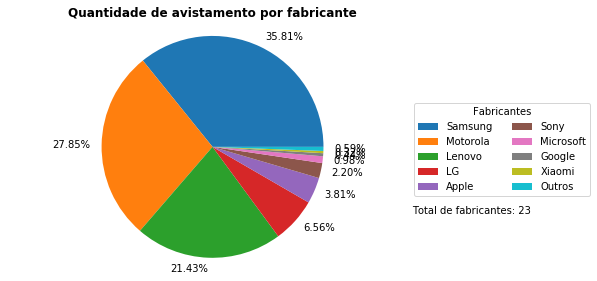

In [7]:
m = makers.filter(col("count") > OTHERS_THRESHOLD).unionAll(others).toPandas()

# 'tab20', 'tab20b', 'tab20c'
# patches.set_cmap("tab20b")

patches, texts = plt.pie(m['count'], labels=m['share'], startangle=0)
plt.title("Quantidade de avistamento por fabricante", {'fontweight':'bold'})
plt.text(1.8, -0.6, "Total de fabricantes: %d" % makers.count())
plt.legend(patches, m['maker'], ncol=2, loc=(1, 0.3), title="Fabricantes")
plt.axis('equal')
plt.tight_layout()

In [55]:
phones_ds = (
    phones
    .withColumn("date", to_date("timestamp"))
    .withColumn("timestamp", to_utc_timestamp(regexp_replace("timestamp", ",", "."), "UTC"))
    .drop("level", "organization", "prefix")
)
phones_ds.groupBy("date").count().toPandas()

,date,count
0,2017-12-06,154123
1,2017-12-10,79781
2,2017-11-30,1424
3,2017-11-29,102802
4,2017-12-07,210231
5,2017-12-11,139670
6,2017-12-12,36031


In [65]:
mins = lambda i: i * (60*60)

IS_PASSENGER_THRESHOLD = 5

sightings_within_5sec = (
    Window.partitionBy("mac")
    .orderBy(col("timestamp").cast("long"))
    .rangeBetween(0, 5)
)

sightings = (
    phones_ds
    .filter(col("date") == "2017-12-10")
    .drop("date")
    # 1) Unique MAC sightings within 5 seconds
    .withColumn("fst_sight", first("timestamp").over(sightings_within_1sec))
    .filter(col("fst_sight") == col("timestamp"))
    .drop("fst_sight")
    # 2) Count distinct sightings in a sliding windown of 5 minutes each minute
    .groupBy(window("timestamp", "3 minutes", "1 minute"))
    .agg(collect_list("mac").alias("addresses"))
    .orderBy("window")
    # 3) Filter adresses only sighted once within the window
    .select("window", explode("addresses").alias("mac"))
    .groupBy("window", "mac").count()
    .filter(col("count") > 5)
    .drop("count")
    # 4) Estimate the occupation
    .groupBy("window").count()
)

sightings.toPandas()

,window,count
0,"(2017-12-10 13:48:00, 2017-12-10 13:51:00)",1
1,"(2017-12-10 13:49:00, 2017-12-10 13:52:00)",5
2,"(2017-12-10 13:50:00, 2017-12-10 13:53:00)",23
3,"(2017-12-10 13:51:00, 2017-12-10 13:54:00)",29
4,"(2017-12-10 13:52:00, 2017-12-10 13:55:00)",30
5,"(2017-12-10 13:53:00, 2017-12-10 13:56:00)",38
6,"(2017-12-10 13:54:00, 2017-12-10 13:57:00)",52
7,"(2017-12-10 13:55:00, 2017-12-10 13:58:00)",59
8,"(2017-12-10 13:56:00, 2017-12-10 13:59:00)",60
9,"(2017-12-10 13:57:00, 2017-12-10 14:00:00)",32


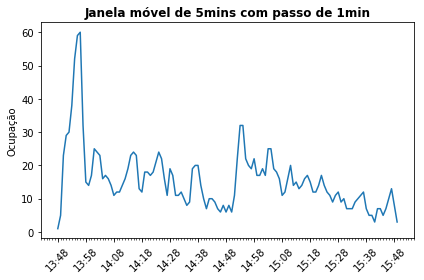

In [64]:
import matplotlib.dates as mdates

r = sightings.toPandas()
r['start'] = r["window"].map(lambda x: x[0])
r = r.set_index('start')

x = np.arange(len(r)) # r["window"].map(lambda x: x[0]).values

fig, ax = plt.subplots()
ax.plot(r.index, r['count'])

ax.set_ylabel("Ocupação")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.title("Janela móvel de 5mins com passo de 1min", {'fontweight': 'demi'})
plt.xticks(rotation=45)
plt.tight_layout()